In [1]:
#import torch
import matplotlib.pyplot as plt
import numpy as np
#import torch
#import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
#import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
#from torchvision import transforms, datasets
import cv2
#from torchvision import transforms, datasets
import pandas as pd
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt


#if torch.cuda.is_available():
#    DEVICE = torch.device('cuda')
#else:
#    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
#print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



Using Pytorch version :  1.10.2  Device :  cuda


In [3]:
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T

In [4]:
# 하이퍼 파라미터 서치 내용. 08. 05
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




In [5]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.
import librosa, librosa.display


pathology = glob('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환 #외부데이터로 가져오기위해서, 번호만 남긴다

    
X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<597:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  597
Healthy:  634
총 데이터수 :  1231
---
훈련 셋 :  984 Counter({'healthy': 507, 'pathology': 477})
테스트 셋 :  247 Counter({'healthy': 127, 'pathology': 120})
---


In [6]:
import pickle

 
#load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

    

In [7]:
phrase_dict

{'1040-phrase.wav': array([ 0.00019198,  0.00072988,  0.00077416, ...,  0.00010608,
        -0.00024016,  0.        ], dtype=float32),
 '1045-phrase.wav': array([-0.00301087, -0.00471198, -0.00369397, ...,  0.00877707,
         0.00960897,  0.        ], dtype=float32),
 '1046-phrase.wav': array([0.00087176, 0.00210954, 0.0017544 , ..., 0.02247776, 0.02591118,
        0.        ], dtype=float32),
 '1047-phrase.wav': array([-0.00218182, -0.0038823 , -0.00290296, ..., -0.00242876,
        -0.00317664,  0.        ], dtype=float32),
 '1048-phrase.wav': array([ 0.0023579 ,  0.00356342,  0.00313498, ..., -0.00019799,
        -0.0001939 ,  0.        ], dtype=float32),
 '1049-phrase.wav': array([ 0.00102539,  0.00163141,  0.00010494, ..., -0.01097467,
        -0.01524004,  0.        ], dtype=float32),
 '105-phrase.wav': array([0.00335465, 0.0054294 , 0.00509842, ..., 0.00176289, 0.00259548,
        0.        ], dtype=float32),
 '1052-phrase.wav': array([ 0.00707356,  0.01187314,  0.00938601, ..

In [8]:

spectros=[]

mels=[]

sr=16000

for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=sr*2 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)
    sig = (sig-sig.mean())/sig.std()
    sig_torch = torch.tensor(sig,dtype=torch.float32)


    #MFCCs = MFCC(sig_torch)

    stft = librosa.stft(sig, win_length=spectro_run_config['win_length'],
                        n_fft=spectro_run_config['n_fft'],
                        hop_length=spectro_run_config['hop_length'])
    
    mel_feature = librosa.feature.melspectrogram(y=sig,
                                                 sr=sr,
                                                 win_length=mel_run_config['win_length'],
                                                 hop_length=mel_run_config['hop_length'],
                                                 n_fft=mel_run_config['n_fft'],
                                                 fmax=mel_run_config['f_max'])
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm


    #padding
    #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    #log_spectrogram = pad2d(log_spectrogram, length)
    #mel_feature = pad2d(mel_feature, length)

    #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    #print(value[0])
    spectros.append(log_spectrogram) # spectrogram
    #print(value[0])
    mels.append(mel_feature) # spectrogram


In [9]:
#mfccs

mfccs=[]

sr=16000

for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=sr*2 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)
    sig = (sig-sig.mean())/sig.std()
    sig_torch = torch.tensor(sig,dtype=torch.float32)
    
    MFCC = T.MFCC(
                    sample_rate = mfcc_run_config["sr"],
                    n_mfcc = mfcc_run_config["n_mfcc"],
                    melkwargs={
                        'n_fft': mfcc_run_config["n_fft"],
                        'n_mels': mfcc_run_config["n_mels"],
                        'hop_length': mfcc_run_config["hop_length"],
                        'mel_scale': mfcc_run_config["mel_scale"],
                        'win_length' : mfcc_run_config["win_length"],
                        'f_max': mfcc_run_config["f_max"]
                    }
                )

    MFCCs=MFCC(sig_torch)
    MFCCs = MFCCs[1:,]
    (nframes, ncoeff) = MFCCs.shape
    cep_lifter = mfcc_run_config["lifter"]

    #log_spectrogram = phrase_scaler[0].transform(log_spectrogram.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)
    #mel_feature=phrase_scaler[1].transform(mel_feature.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)            

    if cep_lifter > 0:
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        MFCCs *= lift
        
    mfccs.append(MFCCs)


In [ ]:
MFCCs

(array([5.15551872e-02, 1.50369296e-02, 1.51283395e-02, 1.74166342e-02,
        2.08871636e-02, 2.32546802e-02, 2.27336437e-02, 1.96409419e-02,
        1.73282713e-02, 1.43970603e-02, 1.11337266e-02, 8.15376365e-03,
        5.55467531e-03, 3.53146938e-03, 2.18774376e-03, 9.68945008e-04,
        5.33224454e-04, 3.38216654e-04, 1.55396841e-04, 6.39869345e-05]),
 array([-80., -76., -72., -68., -64., -60., -56., -52., -48., -44., -40.,
        -36., -32., -28., -24., -20., -16., -12.,  -8.,  -4.,   0.],
       dtype=float32),
 <BarContainer object of 20 artists>)

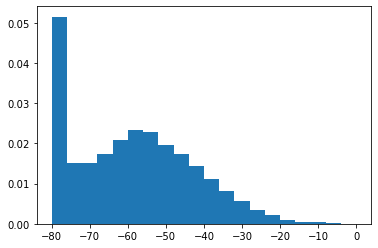

In [10]:
plt.hist(np.round(mels[11]).reshape(-1),density=True,histtype='bar',bins=20)

In [15]:
np.round(mels[11]).mean()

-59.269623

In [19]:
np.round(mels[11]).std()

15.731349

In [16]:
np.round(mels[11][mels[11]>=-70]).mean()

-51.33023

In [18]:
np.round(mels[11][mels[11]>=-70]).std()

11.936755

(array([0.27837417, 0.27664488, 0.42167603, 0.34510532, 0.4449336 ,
        0.29328287, 0.34564203, 0.23782268, 0.24599269, 0.14413675,
        0.14777446, 0.07686899, 0.06911646, 0.03584039, 0.0222437 ,
        0.00900482, 0.00888555, 0.00399552, 0.00232575, 0.00083488]),
 array([-1.5640574 , -1.2708453 , -0.97763336, -0.6844213 , -0.3912093 ,
        -0.09799731,  0.1952147 ,  0.48842672,  0.78163874,  1.0748507 ,
         1.3680627 ,  1.6612748 ,  1.9544867 ,  2.2476988 ,  2.5409107 ,
         2.8341227 ,  3.1273348 ,  3.4205468 ,  3.7137587 ,  4.006971  ,
         4.300183  ], dtype=float32),
 <BarContainer object of 20 artists>)

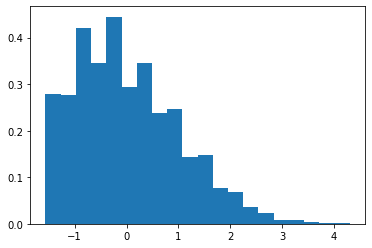

In [21]:

plt.hist( (np.round(mels[11][mels[11]>=-70])+51.33023)/11.936755,density=True,histtype='bar',bins=20)

In [144]:
#import time
#for i in range(600):
    #plt.hist(np.round(spectros[i]).reshape(-1),density=True,histtype='bar',bins=20)
    #plt.show()
    #time.sleep(1)

In [139]:
#import time
#for i in range(600):
    plt.hist(np.round(mels[i]).reshape(-1),density=True,histtype='bar',bins=20)
    #plt.show()
    #time.sleep(1)

IndentationError: unexpected indent (Temp/ipykernel_15108/3236788332.py, line 3)

# global plot

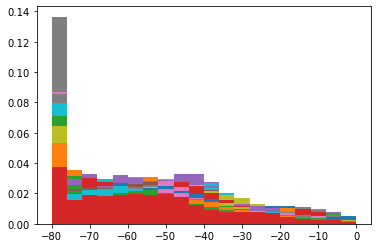

In [9]:

mel_bins=[]

for mel in mels:
    mel_plot=plt.hist(np.round( mel ).reshape(-1),density=True,histtype='bar',bins=20)
    mel_bins.append( mel_plot[0] )
    


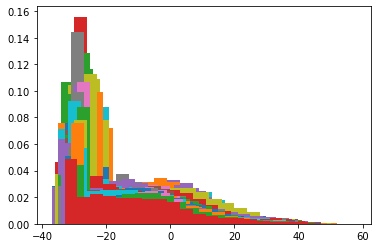

In [10]:
spectro_bins=[]
for spectro in spectros:
    spectro_plot=plt.hist(np.round( spectro ).reshape(-1),density=True,histtype='bar',bins=20)
    spectro_bins.append( spectro_plot[0] )

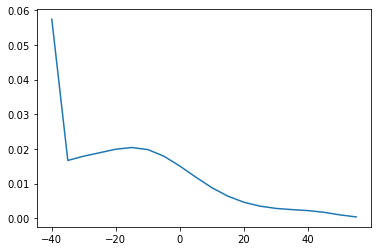

In [11]:
plt.plot(np.arange(-40,60,5),np.array(spectro_bins).mean(axis=0))
#plt.yticks()

(array([0.01016173, 0.01129522, 0.01820581, 0.02454965, 0.02966251,
        0.03162173, 0.02945227, 0.02656981, 0.02051848, 0.01315389,
        0.00771195, 0.00467409, 0.00334256, 0.00310184, 0.00306528,
        0.00272706, 0.00312927, 0.00266917, 0.00337912, 0.00100856]),
 array([-36., -32., -28., -24., -20., -16., -12.,  -8.,  -4.,   0.,   4.,
          8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,  44.],
       dtype=float32),
 <BarContainer object of 20 artists>)

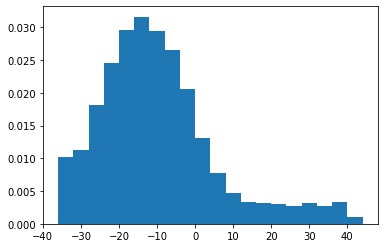

In [12]:
plt.hist(np.round(spectros[8]).reshape(-1),density=True,histtype='bar',bins=20)

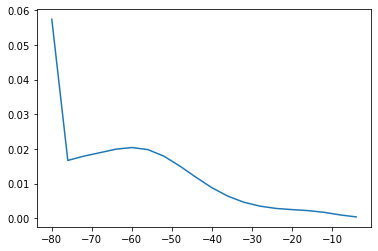

In [13]:

plt.plot(np.arange(-80, 0,4),np.array(spectro_bins).mean(axis=0))
#plt.yticks()

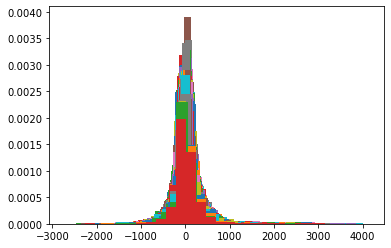

In [34]:
# mfcc
mfcc_bins=[]
for mfcc in mfccs:
    mfcc_plot=plt.hist(np.round( mfcc ).reshape(-1),density=True,histtype='bar',bins=20)
    mfcc_bins.append( mfcc_plot[0] )

(array([1.23090053e-05, 1.64120070e-05, 2.46180105e-05, 3.69270158e-05,
        1.23090053e-04, 5.00566214e-04, 2.50283107e-03, 7.91879339e-04,
        3.32343142e-04, 9.02660386e-05, 4.92360211e-05, 3.28240140e-05,
        8.20600351e-06, 1.64120070e-05, 1.64120070e-05, 0.00000000e+00,
        4.10300176e-06, 1.23090053e-05, 8.20600351e-06, 8.20600351e-06]),
 array([-1427., -1209.,  -991.,  -773.,  -555.,  -337.,  -119.,    99.,
          317.,   535.,   753.,   971.,  1189.,  1407.,  1625.,  1843.,
         2061.,  2279.,  2497.,  2715.,  2933.]),
 <BarContainer object of 20 artists>)

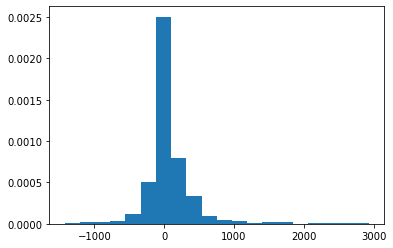

In [42]:
plt.hist(np.round( mfccs[0] ).reshape(-1),density=True,histtype='bar',bins=20)

(array([8.64207133e-06, 4.32103567e-06, 4.32103567e-06, 8.64207133e-06,
        2.59262140e-05, 7.77786420e-05, 4.19140460e-04, 1.85804534e-03,
        1.66359873e-03, 4.36424602e-04, 1.46915213e-04, 6.91365707e-05,
        3.45682853e-05, 2.16051783e-05, 1.72841427e-05, 8.64207133e-06,
        8.64207133e-06, 4.32103567e-06, 0.00000000e+00, 1.29631070e-05]),
 array([-1635., -1428., -1221., -1014.,  -807.,  -600.,  -393.,  -186.,
           21.,   228.,   435.,   642.,   849.,  1056.,  1263.,  1470.,
         1677.,  1884.,  2091.,  2298.,  2505.]),
 <BarContainer object of 20 artists>)

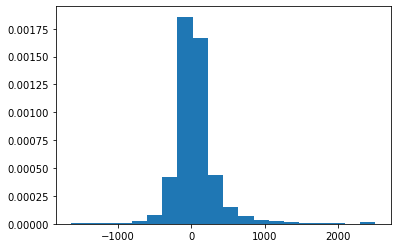

In [43]:
plt.hist(np.round( mfccs[100] ).reshape(-1),density=True,histtype='bar',bins=20)

(array([2.16365356e-05, 2.16365356e-05, 5.19276855e-05, 1.38473828e-04,
        2.72620349e-04, 7.18332983e-04, 2.04248896e-03, 8.00551818e-04,
        3.93784948e-04, 1.94728821e-04, 9.08734496e-05, 8.65461425e-06,
        1.29819214e-05, 2.16365356e-05, 1.73092285e-05, 8.65461425e-06,
        1.73092285e-05, 0.00000000e+00, 0.00000000e+00, 4.32730713e-06]),
 array([-1322. , -1115.3,  -908.6,  -701.9,  -495.2,  -288.5,   -81.8,
          124.9,   331.6,   538.3,   745. ,   951.7,  1158.4,  1365.1,
         1571.8,  1778.5,  1985.2,  2191.9,  2398.6,  2605.3,  2812. ]),
 <BarContainer object of 20 artists>)

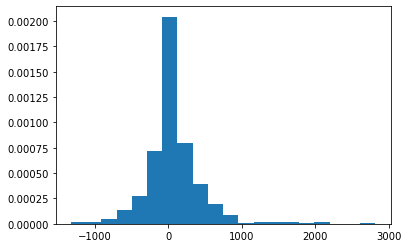

In [45]:
plt.hist(np.round( mfccs[50] ).reshape(-1),density=True,histtype='bar',bins=20)

(array([8.13880239e-06, 4.06940120e-06, 4.06940120e-05, 8.13880239e-05,
        3.78454311e-04, 2.05097820e-03, 1.55451126e-03, 1.70914850e-04,
        6.10410179e-05, 5.29022155e-05, 1.62776048e-05, 4.47634132e-05,
        2.03470060e-05, 4.06940120e-06, 4.06940120e-06, 1.62776048e-05,
        4.06940120e-06, 2.84858084e-05, 0.00000000e+00, 8.13880239e-06]),
 array([-1300. , -1080.2,  -860.4,  -640.6,  -420.8,  -201. ,    18.8,
          238.6,   458.4,   678.2,   898. ,  1117.8,  1337.6,  1557.4,
         1777.2,  1997. ,  2216.8,  2436.6,  2656.4,  2876.2,  3096. ]),
 <BarContainer object of 20 artists>)

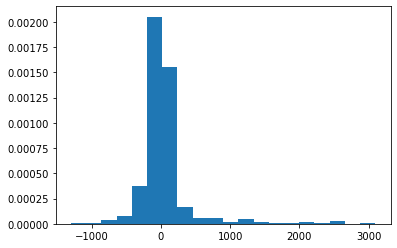

In [44]:
plt.hist(np.round( mfccs[8] ).reshape(-1),density=True,histtype='bar',bins=20)

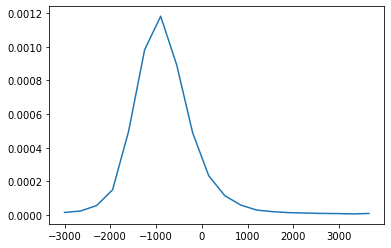

In [36]:

plt.plot(np.arange(-3000, 4000,350),np.array(mfcc_bins).mean(axis=0))
#plt.yticks()

# 샘플 확인

pathology


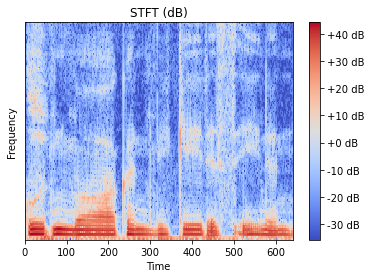

In [26]:

librosa.display.specshow(spectros[8],
                         sr=sr,
                         win_length=spectro_run_config['win_length'],
                         n_fft=spectro_run_config['n_fft'],
                         hop_length=spectro_run_config['hop_length'])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,601,100))
plt.colorbar(format='%+2.0f dB')
plt.title("STFT (dB)")
print(Y[8])
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

pathology


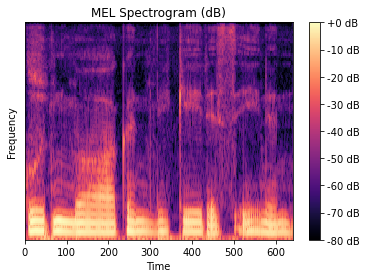

In [25]:

librosa.display.specshow(mels[8],
                         sr=sr,
                         win_length=mel_run_config['win_length'],
                         hop_length=mel_run_config['hop_length'],
                         n_fft=mel_run_config['n_fft'],
                         fmax=mel_run_config['f_max'])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,601,100))
plt.colorbar(format='%+2.0f dB')
plt.title("MEL Spectrogram (dB)")
print(Y[8])


#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

pathology


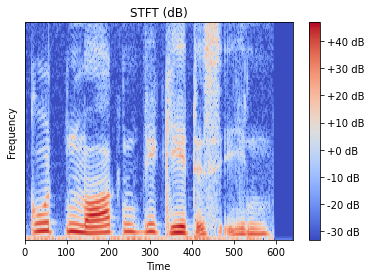

In [27]:

librosa.display.specshow(spectros[0],
                         sr=sr,
                         win_length=spectro_run_config['win_length'],
                         n_fft=spectro_run_config['n_fft'],
                         hop_length=spectro_run_config['hop_length'])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,601,100))
plt.colorbar(format='%+2.0f dB')
plt.title("STFT (dB)")
print(Y[0])
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

pathology


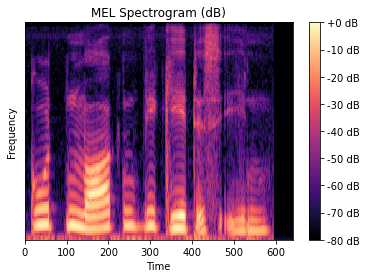

In [28]:

librosa.display.specshow(mels[0],
                         sr=sr,
                         win_length=mel_run_config['win_length'],
                         hop_length=mel_run_config['hop_length'],
                         n_fft=mel_run_config['n_fft'],
                         fmax=mel_run_config['f_max'])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,601,100))
plt.colorbar(format='%+2.0f dB')
plt.title("MEL Spectrogram (dB)")
print(Y[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

In [65]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [60]:
mfccs[8].max()

tensor(3095.7071, dtype=torch.float64)

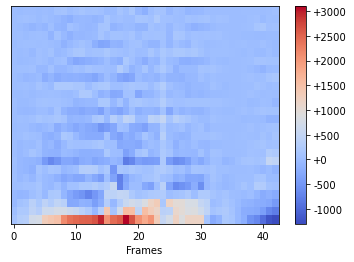

In [75]:
librosa.display.specshow(mfccs[8].numpy(),
                         sr=sr,
                         win_length=mfcc_run_config['win_length'],
                         hop_length=mfcc_run_config['hop_length'],
                         n_fft=mfcc_run_config['n_fft'],
                         fmax=mfcc_run_config['f_max'],
                         x_axis='frames')
plt.colorbar(format='%+2.0f')

In [72]:
mfccs[8].size()

torch.Size([26, 43])

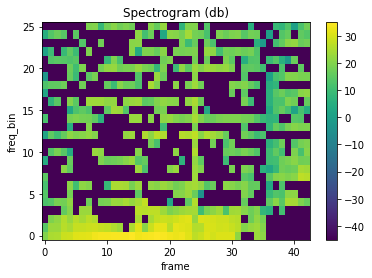

In [66]:
plot_spectrogram(mfccs[8])

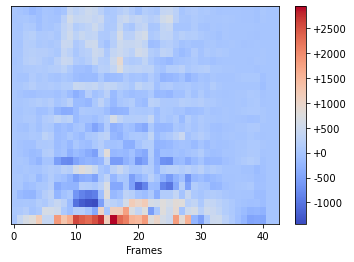

In [67]:
librosa.display.specshow(mfccs[0].numpy(),
                         sr=sr,
                         hop_length=mfcc_run_config["hop_length"],
                         x_axis='frames')
plt.colorbar(format='%+2.0f')

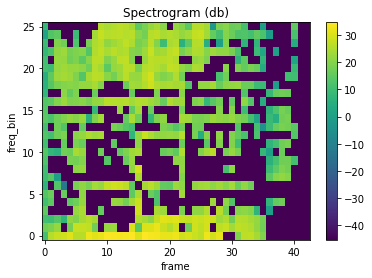

In [68]:
plot_spectrogram(mfccs[0])

# normalize 분포

In [88]:
print('spectrogram 평균 : ',np.array(spectros).mean())
print('spectrogram std : ',np.array(spectros).std())

print('mel 평균 : ',np.array(mels).mean())
print('mel std : ',np.array(mels).std())

spectrogram 평균 :  -11.48049844535476
spectrogram std :  17.14349149885503
mel 평균 :  -54.77237435659213
mel std :  19.41522095182824


In [102]:
print('mfcc 평균 : ',torch.stack(mfccs,dim=0).mean())
print('mfcc std : ',torch.stack(mfccs,dim=0).std())

mfcc 평균 :  tensor(53.5582, dtype=torch.float64)
mfcc std :  tensor(368.3003, dtype=torch.float64)


In [103]:

spectros=[]

mels=[]

sr=16000


spectro_mean = -11.48
spectro_std = 17.14

mel_mean = -54.77
mel_std = 19.41

for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=sr*2 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)
    sig = (sig-sig.mean())/sig.std()
    sig_torch = torch.tensor(sig,dtype=torch.float32)


    #MFCCs = MFCC(sig_torch)

    stft = librosa.stft(sig, win_length=spectro_run_config['win_length'],
                        n_fft=spectro_run_config['n_fft'],
                        hop_length=spectro_run_config['hop_length'])
    
    mel_feature = librosa.feature.melspectrogram(y=sig,
                                                 sr=sr,
                                                 win_length=mel_run_config['win_length'],
                                                 hop_length=mel_run_config['hop_length'],
                                                 n_fft=mel_run_config['n_fft'],
                                                 fmax=mel_run_config['f_max'])
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm


    #padding
    #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    #log_spectrogram = pad2d(log_spectrogram, length)
    #mel_feature = pad2d(mel_feature, length)

    #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    log_spectrogram = (log_spectrogram- spectro_mean)/spectro_std
    mel_feature = (mel_feature-mel_mean)/mel_std
    
    
    #print(value[0])
    spectros.append(log_spectrogram) # spectrogram
    #print(value[0])
    mels.append(mel_feature) # spectrogram


In [104]:
#mfccs

mfccs=[]

sr=16000

for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=sr*2 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)
    sig = (sig-sig.mean())/sig.std()
    sig_torch = torch.tensor(sig,dtype=torch.float32)
    
    MFCC = T.MFCC(
                    sample_rate = mfcc_run_config["sr"],
                    n_mfcc = mfcc_run_config["n_mfcc"],
                    melkwargs={
                        'n_fft': mfcc_run_config["n_fft"],
                        'n_mels': mfcc_run_config["n_mels"],
                        'hop_length': mfcc_run_config["hop_length"],
                        'mel_scale': mfcc_run_config["mel_scale"],
                        'win_length' : mfcc_run_config["win_length"],
                        'f_max': mfcc_run_config["f_max"]
                    }
                )

    MFCCs=MFCC(sig_torch)
    MFCCs = MFCCs[1:,]
    (nframes, ncoeff) = MFCCs.shape
    cep_lifter = mfcc_run_config["lifter"]

    #log_spectrogram = phrase_scaler[0].transform(log_spectrogram.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)
    #mel_feature=phrase_scaler[1].transform(mel_feature.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)            

    if cep_lifter > 0:
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        MFCCs *= lift
    
    MFCCs = (MFCCs-53.5582)/368.3003
    
    #mfcc 평균 :  tensor(53.5582, dtype=torch.float64)
    #mfcc std :  tensor(368.3003, dtype=torch.float64)
    
    mfccs.append(MFCCs)


## mel spectro

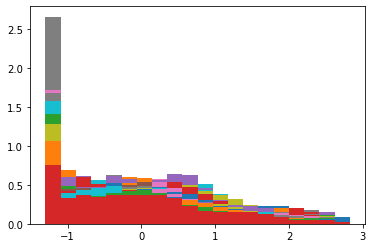

In [115]:

mel_bins=[]

for mel in mels:
    mel_plot=plt.hist(mel.reshape(-1),density=True,histtype='bar',bins=20)
    mel_bins.append( mel_plot[0] )
    


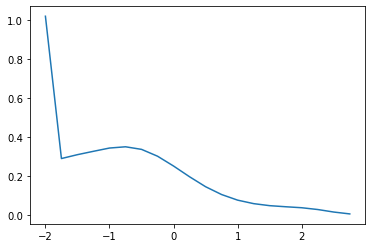

In [121]:

plt.plot(np.arange(-2, 3,0.25),np.array(spectro_bins).mean(axis=0))
#plt.yticks()

(array([1.33761935, 0.24277877, 0.25874717, 0.25046726, 0.25336523,
        0.25377922, 0.27087132, 0.27199502, 0.27104875, 0.25957516,
        0.22834807, 0.1894325 , 0.13886591, 0.10722483, 0.09066501,
        0.09137471, 0.08889074, 0.1248492 , 0.09504153, 0.02756027]),
 array([-1.29984544, -1.0937661 , -0.88768676, -0.68160742, -0.47552808,
        -0.26944874, -0.0633694 ,  0.14270994,  0.34878928,  0.55486862,
         0.76094796,  0.96702731,  1.17310665,  1.37918599,  1.58526533,
         1.79134467,  1.99742401,  2.20350335,  2.40958269,  2.61566203,
         2.82174137]),
 <BarContainer object of 20 artists>)

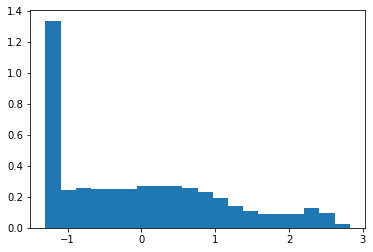

In [110]:
plt.hist(mels[1].reshape(-1),density=True,histtype='bar',bins=20)

(array([0.74454127, 0.40678012, 0.41328576, 0.37442933, 0.36792368,
        0.33977199, 0.34403023, 0.33356206, 0.32640585, 0.2425422 ,
        0.17494266, 0.15081263, 0.13306997, 0.09864921, 0.08380451,
        0.08865417, 0.09279413, 0.08356794, 0.03483476, 0.01809752]),
 array([-1.29984544, -1.0937661 , -0.88768676, -0.68160742, -0.47552808,
        -0.26944874, -0.0633694 ,  0.14270994,  0.34878928,  0.55486862,
         0.76094796,  0.96702731,  1.17310665,  1.37918599,  1.58526533,
         1.79134467,  1.99742401,  2.20350335,  2.40958269,  2.61566203,
         2.82174137]),
 <BarContainer object of 20 artists>)

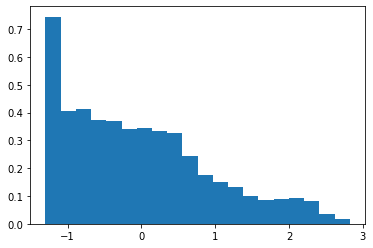

In [111]:
plt.hist(mels[0].reshape(-1),density=True,histtype='bar',bins=20)

(array([1.03906936e+00, 2.86721399e-01, 2.99851055e-01, 3.46987304e-01,
        4.11748016e-01, 4.55158425e-01, 4.32980098e-01, 3.73246442e-01,
        3.33916925e-01, 2.70753004e-01, 2.06997710e-01, 1.53237447e-01,
        1.01014882e-01, 6.55887029e-02, 3.84424318e-02, 1.73878177e-02,
        9.46274697e-03, 6.20993488e-03, 2.72053975e-03, 1.00541803e-03]),
 array([-1.2998455 , -1.0937661 , -0.8876867 , -0.6816074 , -0.47552806,
        -0.2694487 , -0.06336935,  0.14271   ,  0.34878936,  0.5548687 ,
         0.76094806,  0.9670274 ,  1.1731068 ,  1.3791862 ,  1.5852655 ,
         1.7913449 ,  1.9974241 ,  2.2035036 ,  2.4095829 ,  2.6156623 ,
         2.8217416 ], dtype=float32),
 <BarContainer object of 20 artists>)

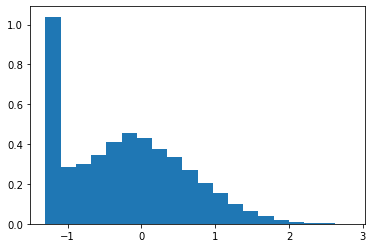

In [113]:
plt.hist(mels[11].reshape(-1),density=True,histtype='bar',bins=20)

(array([0.07859999, 0.12532236, 0.24153676, 0.39542482, 0.49561173,
        0.5551088 , 0.5573562 , 0.5384898 , 0.43203392, 0.29902298,
        0.19800809, 0.13289253, 0.10568718, 0.09900405, 0.09084242,
        0.09172956, 0.1255589 , 0.11976303, 0.13265588, 0.03785103]),
 array([-1.2998455 , -1.0937661 , -0.8876868 , -0.6816074 , -0.4755281 ,
        -0.26944876, -0.06336942,  0.14270993,  0.34878927,  0.5548686 ,
         0.76094794,  0.9670273 ,  1.1731067 ,  1.3791859 ,  1.5852653 ,
         1.7913446 ,  1.997424  ,  2.2035034 ,  2.4095826 ,  2.615662  ,
         2.8217413 ], dtype=float32),
 <BarContainer object of 20 artists>)

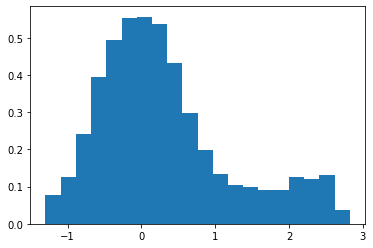

In [122]:
plt.hist(mels[8].reshape(-1),density=True,histtype='bar',bins=20)

## spectro

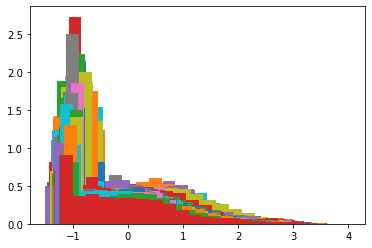

In [118]:
spectro_bins=[]
for spectro in spectros:
    spectro_plot=plt.hist(spectro.reshape(-1),density=True,histtype='bar',bins=20)
    spectro_bins.append( spectro_plot[0] )

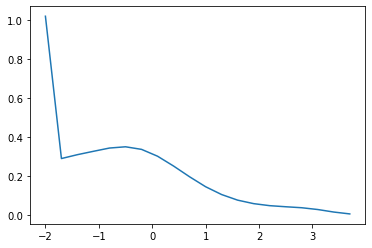

In [124]:

plt.plot(np.arange(-2, 4,0.3),np.array(spectro_bins).mean(axis=0))
#plt.yticks()

(array([1.4188631 , 0.28180894, 0.28400241, 0.27616858, 0.24692229,
        0.23799172, 0.23162021, 0.22498757, 0.2207573 , 0.19871813,
        0.16362257, 0.12690803, 0.08371752, 0.05770921, 0.04580179,
        0.04627182, 0.04413057, 0.0542101 , 0.03248428, 0.00830386]),
 array([-1.33807824, -1.10470601, -0.87133378, -0.63796156, -0.40458933,
        -0.1712171 ,  0.06215513,  0.29552736,  0.52889959,  0.76227182,
         0.99564405,  1.22901627,  1.4623885 ,  1.69576073,  1.92913296,
         2.16250519,  2.39587742,  2.62924965,  2.86262187,  3.0959941 ,
         3.32936633]),
 <BarContainer object of 20 artists>)

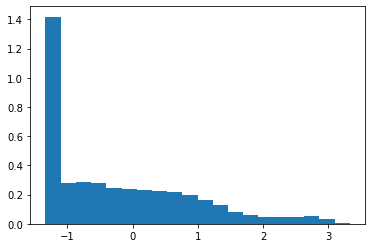

In [127]:
plt.hist(spectros[1].reshape(-1),density=True,histtype='bar',bins=20)

(array([0.87759775, 0.42260896, 0.42114665, 0.35962498, 0.34850094,
        0.32557393, 0.30285583, 0.27246057, 0.2450944 , 0.18994424,
        0.12105877, 0.09802731, 0.07217568, 0.05494125, 0.04287716,
        0.04073591, 0.02971632, 0.0343644 , 0.01566766, 0.0100273 ]),
 array([-1.26442625, -1.03105402, -0.79768179, -0.56430956, -0.33093733,
        -0.0975651 ,  0.13580712,  0.36917935,  0.60255158,  0.83592381,
         1.06929604,  1.30266827,  1.5360405 ,  1.76941273,  2.00278495,
         2.23615718,  2.46952941,  2.70290164,  2.93627387,  3.1696461 ,
         3.40301833]),
 <BarContainer object of 20 artists>)

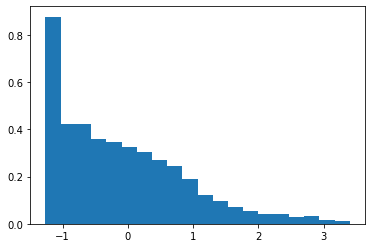

In [128]:
plt.hist(spectros[0].reshape(-1),density=True,histtype='bar',bins=20)

(array([1.23267904e+00, 2.70632664e-01, 2.88337116e-01, 3.42286082e-01,
        3.86625503e-01, 3.90072486e-01, 3.45524021e-01, 2.89642718e-01,
        2.42953167e-01, 1.81065914e-01, 1.21789875e-01, 7.79204913e-02,
        4.80474880e-02, 3.08652885e-02, 1.70777484e-02, 9.29614441e-03,
        5.17032223e-03, 2.50682546e-03, 1.77566803e-03, 7.31157425e-04]),
 array([-0.6424567 , -0.40908447, -0.17571223,  0.05766002,  0.29103225,
         0.5244045 ,  0.75777674,  0.991149  ,  1.2245213 ,  1.4578935 ,
         1.6912657 ,  1.924638  ,  2.1580102 ,  2.3913825 ,  2.6247547 ,
         2.8581269 ,  3.091499  ,  3.3248715 ,  3.5582438 ,  3.791616  ,
         4.024988  ], dtype=float32),
 <BarContainer object of 20 artists>)

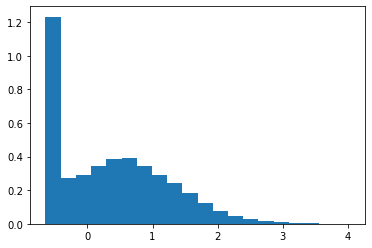

In [129]:
plt.hist(spectros[11].reshape(-1),density=True,histtype='bar',bins=20)

(array([0.20237393, 0.21365459, 0.3322066 , 0.44078342, 0.5211585 ,
        0.52925346, 0.505752  , 0.44015674, 0.32881186, 0.20488076,
        0.11755967, 0.0765104 , 0.05551571, 0.05332227, 0.05050211,
        0.04809966, 0.05295669, 0.04700298, 0.05342672, 0.01107181]),
 array([-1.4172041 , -1.1838319 , -0.95045966, -0.71708745, -0.4837152 ,
        -0.25034297, -0.01697073,  0.2164015 ,  0.44977373,  0.683146  ,
         0.9165182 ,  1.1498904 ,  1.3832626 ,  1.616635  ,  1.8500072 ,
         2.0833793 ,  2.3167517 ,  2.550124  ,  2.7834961 ,  3.0168684 ,
         3.2502406 ], dtype=float32),
 <BarContainer object of 20 artists>)

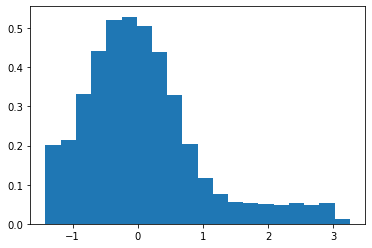

In [130]:
plt.hist(spectros[8].reshape(-1),density=True,histtype='bar',bins=20)

## mfcc

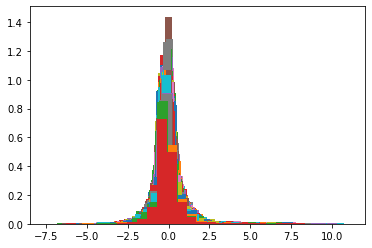

In [136]:
# mfcc
mfcc_bins=[]
for mfcc in mfccs:
    mfcc_plot=plt.hist(mfcc.reshape(-1),density=True,histtype='bar',bins=20)
    mfcc_bins.append( mfcc_plot[0] )

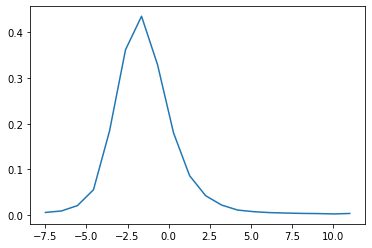

In [137]:

plt.plot(np.arange( -7.5, 12, 0.975 ),np.array(mfcc_bins).mean(axis=0))
#plt.yticks()

(array([0.00453339, 0.00604451, 0.00906677, 0.01360016, 0.04533386,
        0.18435769, 0.92329957, 0.29013669, 0.12240142, 0.03324483,
        0.01813354, 0.01208903, 0.00302226, 0.00604451, 0.00604451,
        0.        , 0.00151113, 0.00453339, 0.00302226, 0.00302226]),
 array([-4.02024947, -3.42833798, -2.83642648, -2.24451499, -1.65260349,
        -1.060692  , -0.4687805 ,  0.12313099,  0.71504248,  1.30695398,
         1.89886547,  2.49077697,  3.08268846,  3.67459996,  4.26651145,
         4.85842295,  5.45033444,  6.04224594,  6.63415743,  7.22606892,
         7.81798042]),
 <BarContainer object of 20 artists>)

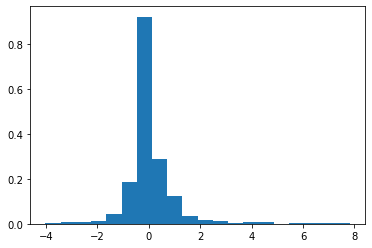

In [132]:
plt.hist(mfccs[0].reshape(-1),density=True,histtype='bar',bins=20)

(array([0.00299773, 0.00149887, 0.01498867, 0.02847847, 0.14239237,
        0.75842671, 0.5680706 , 0.06295241, 0.02248301, 0.01948527,
        0.00599547, 0.01648754, 0.00749434, 0.00149887, 0.00149887,
        0.00599547, 0.00149887, 0.01049207, 0.        , 0.00299773]),
 array([-3.67510489, -3.07835122, -2.48159755, -1.88484389, -1.28809022,
        -0.69133656, -0.09458289,  0.50217078,  1.09892444,  1.69567811,
         2.29243177,  2.88918544,  3.48593911,  4.08269277,  4.67944644,
         5.2762001 ,  5.87295377,  6.46970744,  7.0664611 ,  7.66321477,
         8.25996843]),
 <BarContainer object of 20 artists>)

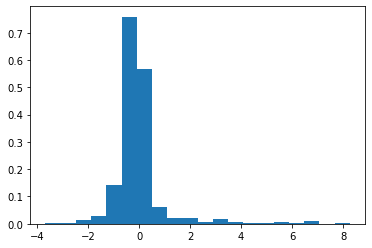

In [133]:
plt.hist(mfccs[8].reshape(-1),density=True,histtype='bar',bins=20)

(array([0.00180944, 0.        , 0.        , 0.00180944, 0.        ,
        0.00904721, 0.01447554, 0.03256996, 0.14294592, 1.00604976,
        0.4650266 , 0.17551588, 0.07599656, 0.04523605, 0.02352275,
        0.00723777, 0.00723777, 0.00723777, 0.        , 0.00723777]),
 array([-4.88755581, -4.39322973, -3.89890365, -3.40457757, -2.91025148,
        -2.4159254 , -1.92159932, -1.42727324, -0.93294715, -0.43862107,
         0.05570501,  0.55003109,  1.04435718,  1.53868326,  2.03300934,
         2.52733543,  3.02166151,  3.51598759,  4.01031367,  4.50463976,
         4.99896584]),
 <BarContainer object of 20 artists>)

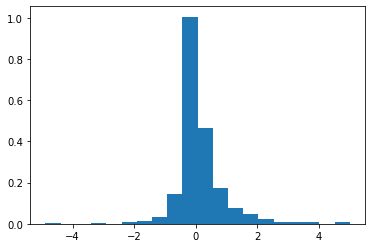

In [134]:
plt.hist(mfccs[11].reshape(-1),density=True,histtype='bar',bins=20)

(array([0.00797023, 0.00637619, 0.00956428, 0.04144521, 0.12592967,
        0.41604611, 0.81933986, 0.19606771, 0.08129637, 0.0239107 ,
        0.01434642, 0.01115832, 0.01115832, 0.        , 0.00478214,
        0.00318809, 0.00318809, 0.00318809, 0.        , 0.00318809]),
 array([-3.51259864, -2.95147672, -2.3903548 , -1.82923288, -1.26811097,
        -0.70698905, -0.14586713,  0.41525479,  0.97637671,  1.53749863,
         2.09862055,  2.65974247,  3.22086438,  3.7819863 ,  4.34310822,
         4.90423014,  5.46535206,  6.02647398,  6.5875959 ,  7.14871782,
         7.70983973]),
 <BarContainer object of 20 artists>)

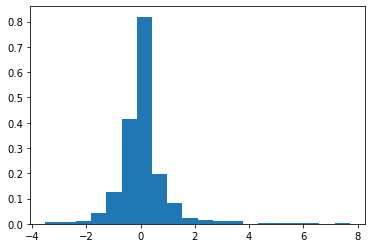

In [135]:
plt.hist(mfccs[15].reshape(-1),density=True,histtype='bar',bins=20)